# HYPSO-1 Anomaly Detection using Independent Component Analysis (ICA) 

## Topics
- Mixing and Unmixing Signals
- Independent Component Analysis
- Python demo of ICA using HYPSO-1 captures


## Background

### Mixing Signals

- Hyperspectral imagers capture reflected light from various sources on the Earth's surface. 
- The data observed is the combination or mixture of the signals from different sources within the scene. 
- The sources can include different materials, vegetation, atmospheric effects, and substances in the ocean (such as algae).

<img src="./Images/mixed_signal_2.drawio.png" height="600">



### Unmixing Signals

- One approach to approximating the mixture of signals is through a **Linear Mixing Model**.
- This assumes that the spectrum observed at each pixel in a hyperspectral image is the linear combination of the spectra of individual sources present in the pixel.
    - This can be described by the matrix equation: $X = A S$
    - $X$ is the matrix containing the observed mixture data
    - $A$ is a **mixing matrix** of coefficients relating the sources to the mixture data
    - $S$ is the matrix containing the sources
- If information about the linear mixing is obtained, then the mixed hyperspectral data can be decomposed or unmixed back into the individual sources. 
    - This is equivalent to inverting the equation above: $A^{-1} X = W X = S$
    - An **unmixing matrix** $A^{-1}$ or $W$ is applied to the mixture data yielding the sources

<img src="./Images/mixed_signal.drawio.png" height="300">

- The main challenege of the unmixing process is lack of knowledge about:
    1. the number of sources
    2. the amount of that each source contributes to the overall mixed signal
- In other words, we have no prior information about the scene.
- This is a type of problem called **blind source separation**.

## Indpendent Component Analysis (ICA):

### What is ICA?
- ICA is one method for solving blind source separation problems.
- It is an **unsupervised** method meaning that it does not require training data.
- The goal of ICA is to find a set of **independent components** that approximate the observed data when linearly combined.

### Assumptions
- ICA uses several assumptions about the data:
    1. The observed mixture is a **linear combination** of the sources
    2. The sources are **independent** from one another (one of the difference between ICA and PCA)
    3. The sources are **non-Gaussian** signals


### Key Principle 1: Central Limit Theorem
- The third assumption is key to understanding how ICA works.
    - It states that the individual sources making up the mixture data will **not** have distributions resembling Gaussian (i.e. normal) distributions.
    - According to the **Central Limit Theorem (CLT)**, when the non-Gaussian sources are combined, the distribution of the linear combinations in the mixed data will trend toward a Gaussian distribution.
    - ICA reverses the CLT, operating on the assumption that for linearly mixed data, the distribution of the constituent sources will be non-Gaussian.


<img src="./Images/CLT.webp" height="300">


### Key Principle 2: Negentropy
- Problem: In order to identify non-Gaussian signals, we need some method to measure the amount of 'non-Guassinity'
- Solution: **Negntropy** is a metric that quantifies how close a distribution is to being Gaussian (normal).
    - For a Gaussian distribution, negentropy is zero
    - All other non-Gaussian distributions will have a positive negentropy value
    - Using negentropy, the mixture data can be analyzed to indentify potential sources with high non-Gaussinity

### Finding Independent Components
- Recall the unmixing equation: $W X = S$
    - $W$ is an unmixing matrix
    - $X$ is the mixed data
    - $S$ is the source data
- Through an iterative process, ICA gradually estimates the unmixing matrix $X$ such that it produces independent components in $S$ which maximize negentropy.
    - The indepdent components found using this process are non-Gaussian and correspond to independent sources contributing to the mixture data.
    - This is the approach taken by a popular implementation called **FastICA**

### What does ICA produce?
- ICA produces two useful things for hyperspectral data:
    1. Indpendent components: The ICs can be plotted as maps describing the spatial distribution of the source
    2. Un-mixing matrix: Each row of the estimated un-mxing matrix $W$ can be plotted and interpreted as a spectrum for one of the ICs.'
- In some cases, the sign of the indepdent components can be entirely reversed. 
    - Due to the linear mixture model, there is no direct way of determining the correct sign of the indepdent compontents.




## Further Reading
- [SciKit-Learn FastICA Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html)
- [Independent Component Analysis: Algorithms and Applications](https://www.cs.helsinki.fi/u/ahyvarin/papers/NN00new.pdf)

# Python Demo

## Download HYPSO-1 Data

Download HYPSO-1 capture: [OneDrive](https://studntnu-my.sharepoint.com/:f:/g/personal/camerop_ntnu_no/EqBGN4SM0GNBlLwBQO_wHVEB61jdbnSzeRkt2_LHR9E7xg?e=e2epJg) or [NSSL SharePoint](https://studntnu.sharepoint.com/sites/o365_HYPSO-project/Shared%20Documents/Forms/AllItems.aspx?id=%2Fsites%2Fo365%5FHYPSO%2Dproject%2FShared%20Documents%2FHYPSO%20Project%2FOperations%2FRecords%2FLogs&p=true&ga=1) (NTNU login required)

In [141]:
path_to_bip = '.bip file path here'

#path_to_bip = "/home/cameron/Nedlastinger/20220712_CaptureDL_00_erie/erie-2022-07-12.bip"
#path_to_bip = "/home/cameron/Nedlastinger/20220719_CaptureDL_00_GriegBC/grieg-2022-07-19.bip"
#path_to_bip = "/home/cameron/Nedlastinger/griegBC_2022-07-13/griegBC_2022-07-13.bip"
#path_to_bip = "/home/cameron/Nedlastinger/griegBC_2022-08-30_1838Z/griegBC_2022-08-30_1838Z.bip"

## Import Packages

In [142]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition as de
import copy
import time
import numpy.ma as ma


## Functions

In [143]:
#a few functions copied from Marie's calibration code, should update to just use as a library

def pixel_to_wavelength(x, spectral_coeffs):
    if len(spectral_coeffs) == 2:
        w = spectral_coeffs[1] + spectral_coeffs[0]*x
    elif len(spectral_coeffs) == 3:
        w = spectral_coeffs[2] + spectral_coeffs[1]*x + spectral_coeffs[0]*x*x
    elif len(spectral_coeffs) == 4:
        w = spectral_coeffs[3] + spectral_coeffs[2]*x + spectral_coeffs[1]*x*x + spectral_coeffs[0]*x*x*x
    elif len(spectral_coeffs) == 5:
        w = spectral_coeffs[4] + spectral_coeffs[3]*x + spectral_coeffs[2]*x*x + spectral_coeffs[1]*x*x*x + spectral_coeffs[0]*x*x*x*x
    else: 
        print('Please update spectrally_calibrate function to include this polynomial.')
        print('Returning 0.')
        w = 0
    return w

def apply_spectral_calibration(x_start, x_stop, image_width, spectral_coeffs):  
    x = np.linspace(x_start,x_stop,image_width) 
    w = pixel_to_wavelength(x, spectral_coeffs)
    return w

def apply_radiometric_calibration(frame, exp, background_value, radiometric_calibration_coefficients):
    ''' Assumes input is 12-bit values, and that the radiometric calibration
    coefficients are the same size as the input image.
    
    Note: radiometric calibration coefficients have original size (684,1080),
    matching the "normal" AOI of the HYPSO-1 data (with no binning).'''
    
    frame = frame - background_value
    frame_calibrated = frame * radiometric_calibration_coefficients / exp
    
    return frame_calibrated

def calibrate_cube(cube, metadata, spectral_coeffs, rad_coeffs, background_value):
    
    [exp, image_height, image_width, x_start, x_stop, y_start, y_stop, bin_x] = metadata
    
    ## Spectral calibration
    w = apply_spectral_calibration(x_start, x_stop, image_width, spectral_coeffs)
    # x = np.linspace(x_start,x_stop,image_width) 
    # w = util.pixel_to_wavelength(x, spectral_coeffs)
    
    ## Radiometric calibration
    num_frames = cube.shape[0]
    cube_calibrated = np.zeros([num_frames, image_height, image_width])
    for i in range(num_frames):
        frame = cube[i,:,:]
        frame_calibrated = apply_radiometric_calibration(frame, exp, background_value, rad_coeffs)
        cube_calibrated[i,:,:] = frame_calibrated
    
    ## Smile and keystone correction
    # TODO
    
    return cube_calibrated, w, metadata


def atgp(img, n=0):
    if n == 0:
        n = img.shape[-1]
        
    targets = np.zeros((n, img.shape[-1]))
    Po = np.eye(img.shape[-1])
    sigs = np.zeros(n, dtype=np.uint64)
    
    for i in range(n):
        
        orth = img@Po
        sigs[i] = np.argmax(np.multiply(orth, orth).sum(axis=1))
        #print(np.mean((orth**2).sum(axis=-1)))
        targets[i,:] = orth[sigs[i]]
        
        #The normalization doesn't really matter, but...
        targets[i,:] = targets[i,:]#/np.sqrt((targets[i]**2).sum())
        U = np.array([targets[j] for j in range(i+1)])
        Po = np.eye(img.shape[-1])-np.linalg.pinv(U)@U
        
    return targets, sigs

def osp_ica(ica_data, n_components=0, use_faster_ica=0):
    if n_components==0:
        n_components = ica_data.shape[-1]
        
    # initially do the pca conversion
    pca = de.PCA(n_components=n_components)
    xs = pca.fit_transform(ica_data)
    
    # in the PCA space, do OSP calc
    osp_t, _ = atgp(xs, n=n_components)
    #print(osp_t.shape)
    
    if use_faster_ica:
        # now do ica (FasterICA)
        ica = FasterICA(n_components=n_components, whiten='unit-variance', w_init = osp_t)
        ica.fit(ica_data)
    else:
        # now do ica (FastICA)
        ica = de.FastICA(n_components=n_components, whiten='unit-variance', w_init = osp_t)
        ica.fit(ica_data)

    return ica, pca, xs


def reshape_masked_data(data, mask, n_components, x=956, y=684):
    print(data.shape)
    empty = np.empty((x, y, n_components))
    #empty[~mask] = data
    empty[~mask] = data
    return empty


## Setup & Load Data

Data is loaded from unprocessed .bip files.

In [144]:
# Open .bip file containing the hyperspectral datacube
cube = np.fromfile(path_to_bip, dtype='uint16')

print(cube.shape)

(78468480,)


## Calibration

TODO: Update for wide captures

In [145]:
# type in the relevant path the the calibration coeffs on your 
#coeff_path = '/home/cameron/Projects/cal-char-corr/FM-calibration/Coefficients/'
coeff_path = './Coefficients/'
spectral_coeffs = np.genfromtxt(coeff_path+'spectral_coeffs_FM_order2.csv', delimiter=',')
rad_coeffs = np.genfromtxt(coeff_path + 'rad_coeffs_FM_binx9_2022_08_06_Finnmark_recal_a.csv', delimiter=',')

# this is just a bunch of calibration stuff that shouldn't change much
# you do need to check the exposure (exp) in the capture config.ini file

bin_x = 9 # binning factor
background_value = 8*bin_x
x_start = 428 # aoi_x
x_stop = 1508 # aoi_x + column_count 
y_start = 266 # aoi_y
y_stop = 950 # aoi_y + row_count
exp = 50/1000 # convert ms to s

image_height = 684 # row_count
image_width = 120 # column_count/bin_factor
im_size = image_height*image_width

metad = [exp, image_height, image_width, x_start, x_stop, y_start, y_stop, bin_x]
cube = cube.reshape((-1,image_height,image_width))

In [146]:
# Calibrate the data
calibrated_data, wl, metadata = calibrate_cube(cube[:,:,::-1], 
                                    metad, 
                                    spectral_coeffs, 
                                    rad_coeffs, 
                                    background_value)

calibrated_data.shape

(956, 684, 120)

## Plot RGB Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


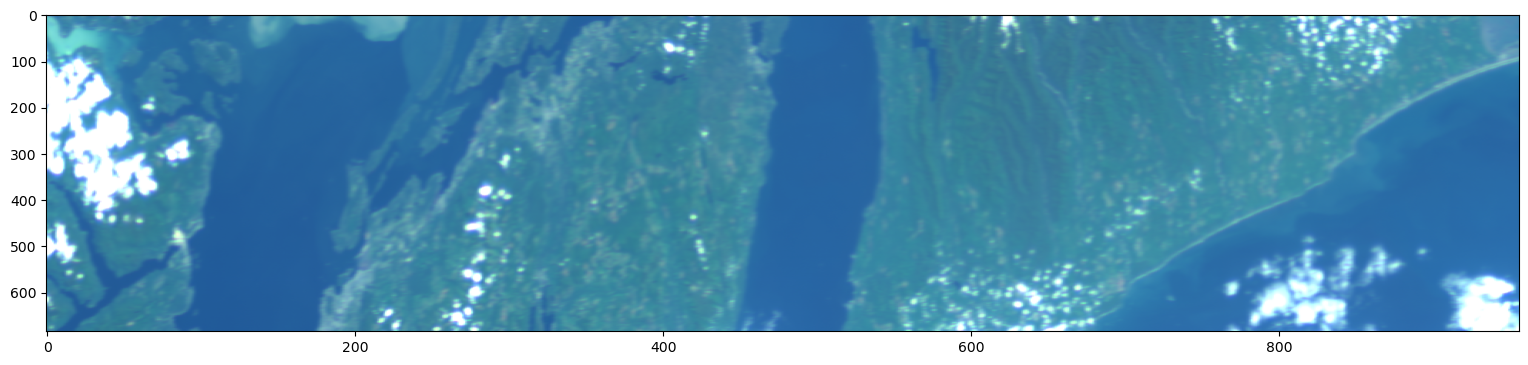

In [147]:
gain = 55
bands = [80, 40, 15] # red, green, blue
rgb_guess = calibrated_data[:,:,bands]/gain 
fig, ax = plt.subplots(1,1,figsize=(19,19))
plt.imshow(np.rot90(rgb_guess), aspect=.3)

## Generate Land Mask

Use PCA to find regions of the image with unobscured open water and create a boolean mask. This should be replaced with the SVM classifier. 

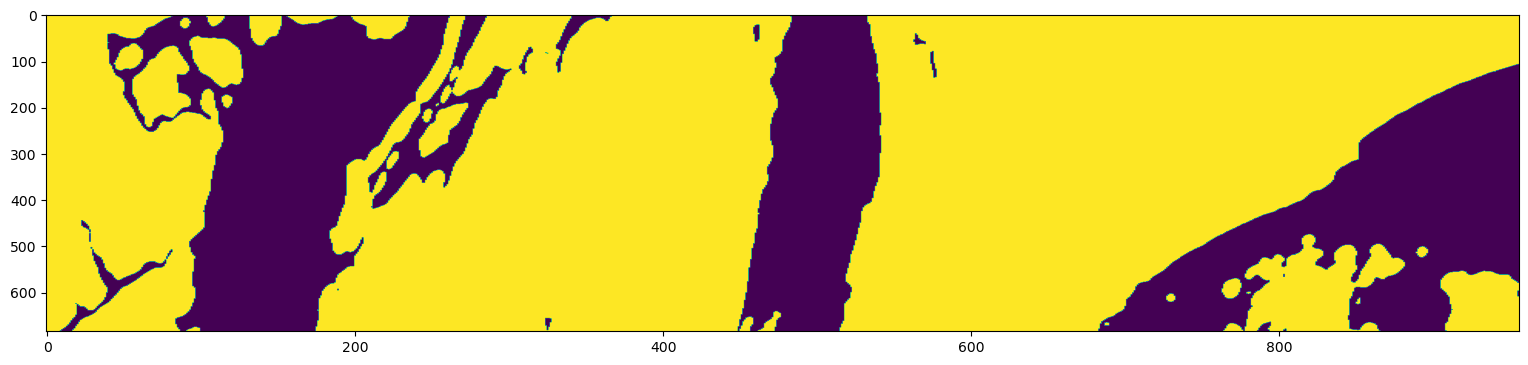

In [148]:
# Flatten datacube from 3D to 2D
calibrated_data_flattened = calibrated_data.reshape((calibrated_data.shape[0]*calibrated_data.shape[1], calibrated_data.shape[2])) 

# Generate PCA components from flattened 2D datacube
pca = de.PCA(n_components=2)
xs = pca.fit_transform(calibrated_data_flattened)

# Reshape the matrix containing the PCA components from 2D to 3D
xs = xs.reshape(calibrated_data.shape[0], calibrated_data.shape[1], 2)

# Use first PCA component and assume that it can be used as a land_mask
land_mask = xs[:,:,0] 

# Normalize between 0 and 1
land_mask = (land_mask - np.min(land_mask))/np.ptp(land_mask) 

# Create boolean mask
land_mask = land_mask > 0.05*land_mask.max() 

# Plot the land mask
fig, ax = plt.subplots(1,1,figsize=(19,19))
plt.imshow(np.rot90(land_mask), aspect=.3)

# Combine masks (optional)
#mask = (land_mask | cloud_mask | saturated_mask)
mask = land_mask


## Delining

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


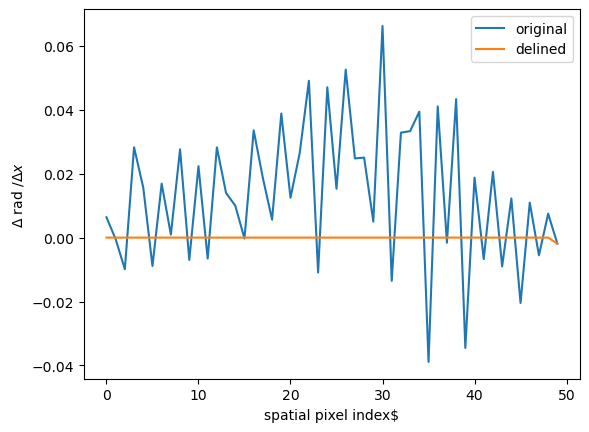

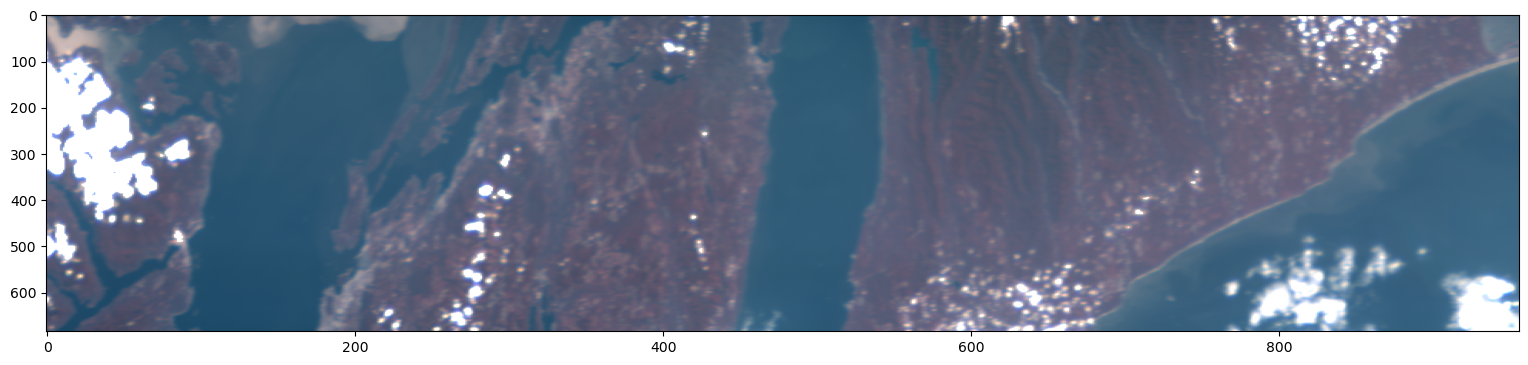

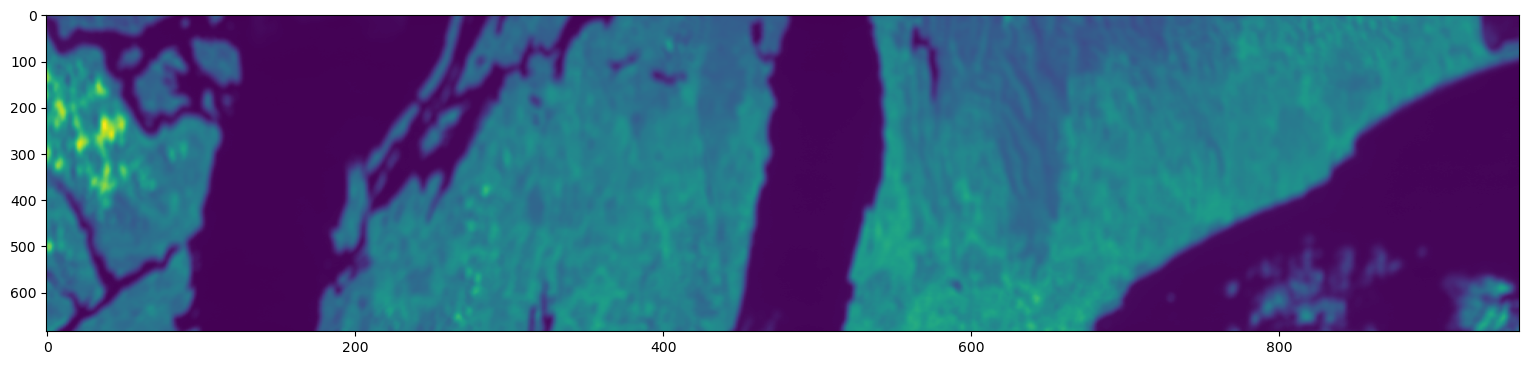

In [149]:
wm = land_mask

# now we look at the (masked to only water) line-by-line pixel difference to search for hot pixels
diff = calibrated_data[:,1:,100] - calibrated_data[:,:-1,100] 
wm_t = wm[:,:-1]
wm_t[wm[:,1:]] = 1 
diff[wm_t]=0

if False:
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    plt.imshow(diff)
    plt.colorbar()

# determine correction
diff = np.zeros((956,683,120))
diff[:] = calibrated_data[:,1:,:] - calibrated_data[:,:-1,:]
diff[wm_t]=0
corrections = np.zeros((684,120))
for i in range(0,683):
    corrections[i,:] = np.median(diff[:,i][~wm_t[:,i]], axis=0)
corrections[:] -= np.mean(corrections, axis=0)
cumulative = np.zeros((684, 120))
cumulative[0] = corrections[0]
for i in range(1,684):
    cumulative[i] = corrections[i] + cumulative[i-1]
    
if False:
    # now, we can plot the additive correction applied to diferent lines of the cube. 
    # y-axis: spatial pixel index
    # x-axis: wavelength number
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    plt.imshow(cumulative, aspect = 0.3)
    plt.xlabel('band index')
    plt.ylabel('spatial pixel index')

# make the de-lined cube
cube_delined = copy.deepcopy(calibrated_data)
cube_delined[:,1:] -= cumulative[:-1]

# check that the cube is actually de-lined
diff2 = cube_delined[:,1:,:] - cube_delined[:,:-1,:] 
diff2[wm_t]=0
corrections2 = np.zeros((684,120))
for i in range(0,683):
    corrections2[i,:] = np.median(diff2[:,i][~wm_t[:,i]], axis=0)
corrections2[:] -= np.mean(corrections2, axis=0)


if True:
    plt.plot(corrections[-50:,90], label = 'original')
    plt.plot(corrections2[-50:,90], label = 'delined')
    plt.ylabel('$\Delta$ rad /$\Delta x$')
    plt.xlabel('spatial pixel index$')
    plt.legend()
    
if False:
    # show a band of the image after de-lining to show that the lines are actually gone
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    plt.imshow(diff2[:,:,100])


saturated = np.sum(cube, axis=2) > 2*10**6

# plot a RGB representation of the delined image
rgb_delined = cube_delined[:,:,[40,25, 15]]/50 -0.3 # @ np.array([1,1,.8])-0.1
rgb_delined= np.multiply(rgb_delined, np.array([1.2,1.0,1.1]))
rgb_delined[saturated, :] = 1
fig, ax = plt.subplots(1,1,figsize=(19,19))
plt.imshow(np.rot90(rgb_delined), aspect=0.3)

fig, ax = plt.subplots(1,1,figsize=(19,19))
plt.imshow(np.rot90(cube_delined[:,:,109]), aspect=.3)
#plt.scatter([92],[550],color='b')


## Remove empty bands

The first four bands of HYPSO-1 data are all zero so we remove them.

In [150]:
# Drop first four channels
ica_data = calibrated_data[:,:,4:] 
ica_wl = wl[4:]

## Plot Masked RGB Image

Plot the datacube as an RGB image with land and cloud regions masked out leaving only open water.

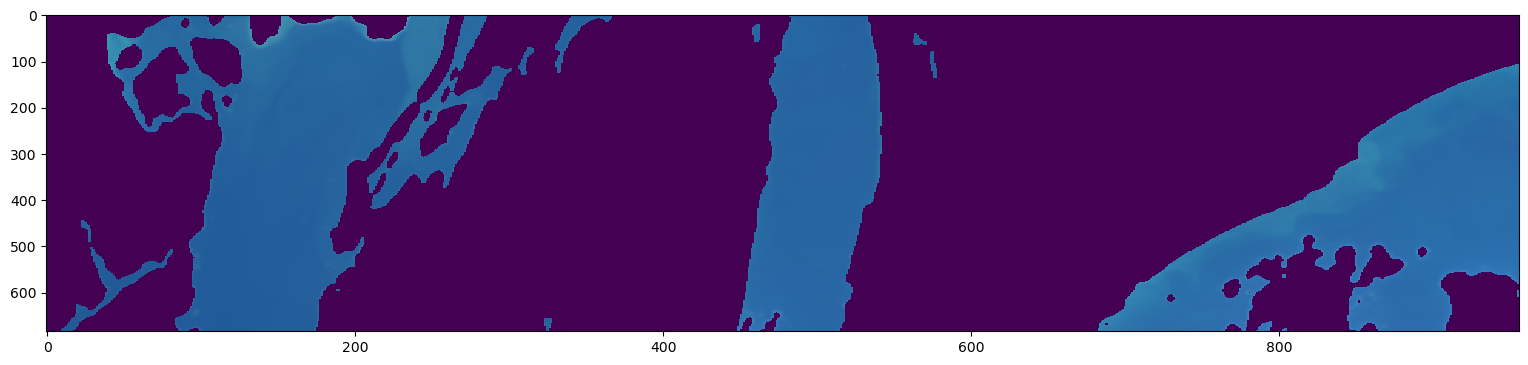

In [151]:
# Create mask with same dimensions as image
mask_rgb = np.zeros_like(rgb_delined, dtype=bool)

# Copy your mask to all dimensions (i.e. colors) of your image
for i in range(3): 
    mask_rgb[:,:,i] = mask.copy()

# Plot RGB image with land mask applied
if True:
    temp = ma.masked_array(rgb_guess, mask=mask_rgb)
    mx = ma.masked_array(np.zeros_like(ica_data[:,:,0]), mask=~mask)
    fig, ax = plt.subplots(1,1,figsize=(19,19))
    ax.imshow(np.rot90(temp), aspect=0.3)
    ax.imshow(np.rot90(mx), aspect=0.3)


## Run ICA

This cell applies ICA to the masked HYPSO-1 datacube using an implementation of ICA called FastICA. Only the water regions in the image are processed by FastICA. 

Before FastICA is run, a procedure called Automated Target Generation Process (ATGP) is performed to estimate an initial unmixing matrix for FastICA. This step is based on PCA.

The end results of this cell are the independent components (ICs) and the ICA unmixing matrix containing spectra for each component.

In [152]:
# Define the number of ICA components to generate
n_components = 5

# Mask the ICA input data
ica_data_masked = ica_data[~mask]
print(ica_data_masked.shape)

# Make copy of the data
ica_input = ica_data_masked


# Run ICA
tic = time.perf_counter()
ica_transformer, pca_transformer, pca_output = osp_ica(ica_input, n_components=n_components, use_faster_ica=False)
ica_output = ica_transformer.fit_transform(ica_input)
toc = time.perf_counter()

# Reshape data
ica_components = reshape_masked_data(ica_output, mask, n_components)
pca_components = reshape_masked_data(pca_output, mask, n_components)

# Retrieve weights
ica_mixing = ica_transformer.mixing_
ica_unmixing = ica_transformer.components_.T
pca_unmixing = pca_transformer.components_.T


(198746, 116)
(198746, 5)
(198746, 5)


# Plot and Save Results

The following cells plot and saves the RGB image, ICA results, and PCA results. The plots are saved to .png files in the same directory as the notebook.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


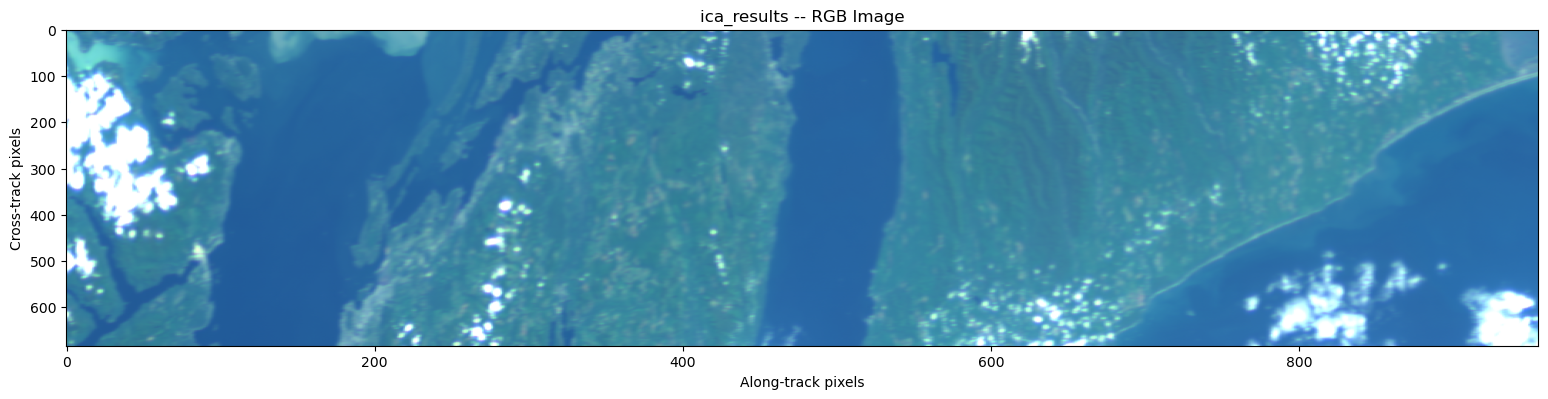

In [153]:
# Description used in plot file names
description = 'ica_results'

# Plot RGB image
fig, ax = plt.subplots(1,1,figsize=(19,6))
plt.imshow(np.rot90(rgb_guess), aspect=0.3)
plt.title(description + ' -- RGB Image')
plt.ylabel('Cross-track pixels')
plt.xlabel("Along-track pixels")

plt.savefig("./" + description + '_rgb.png')

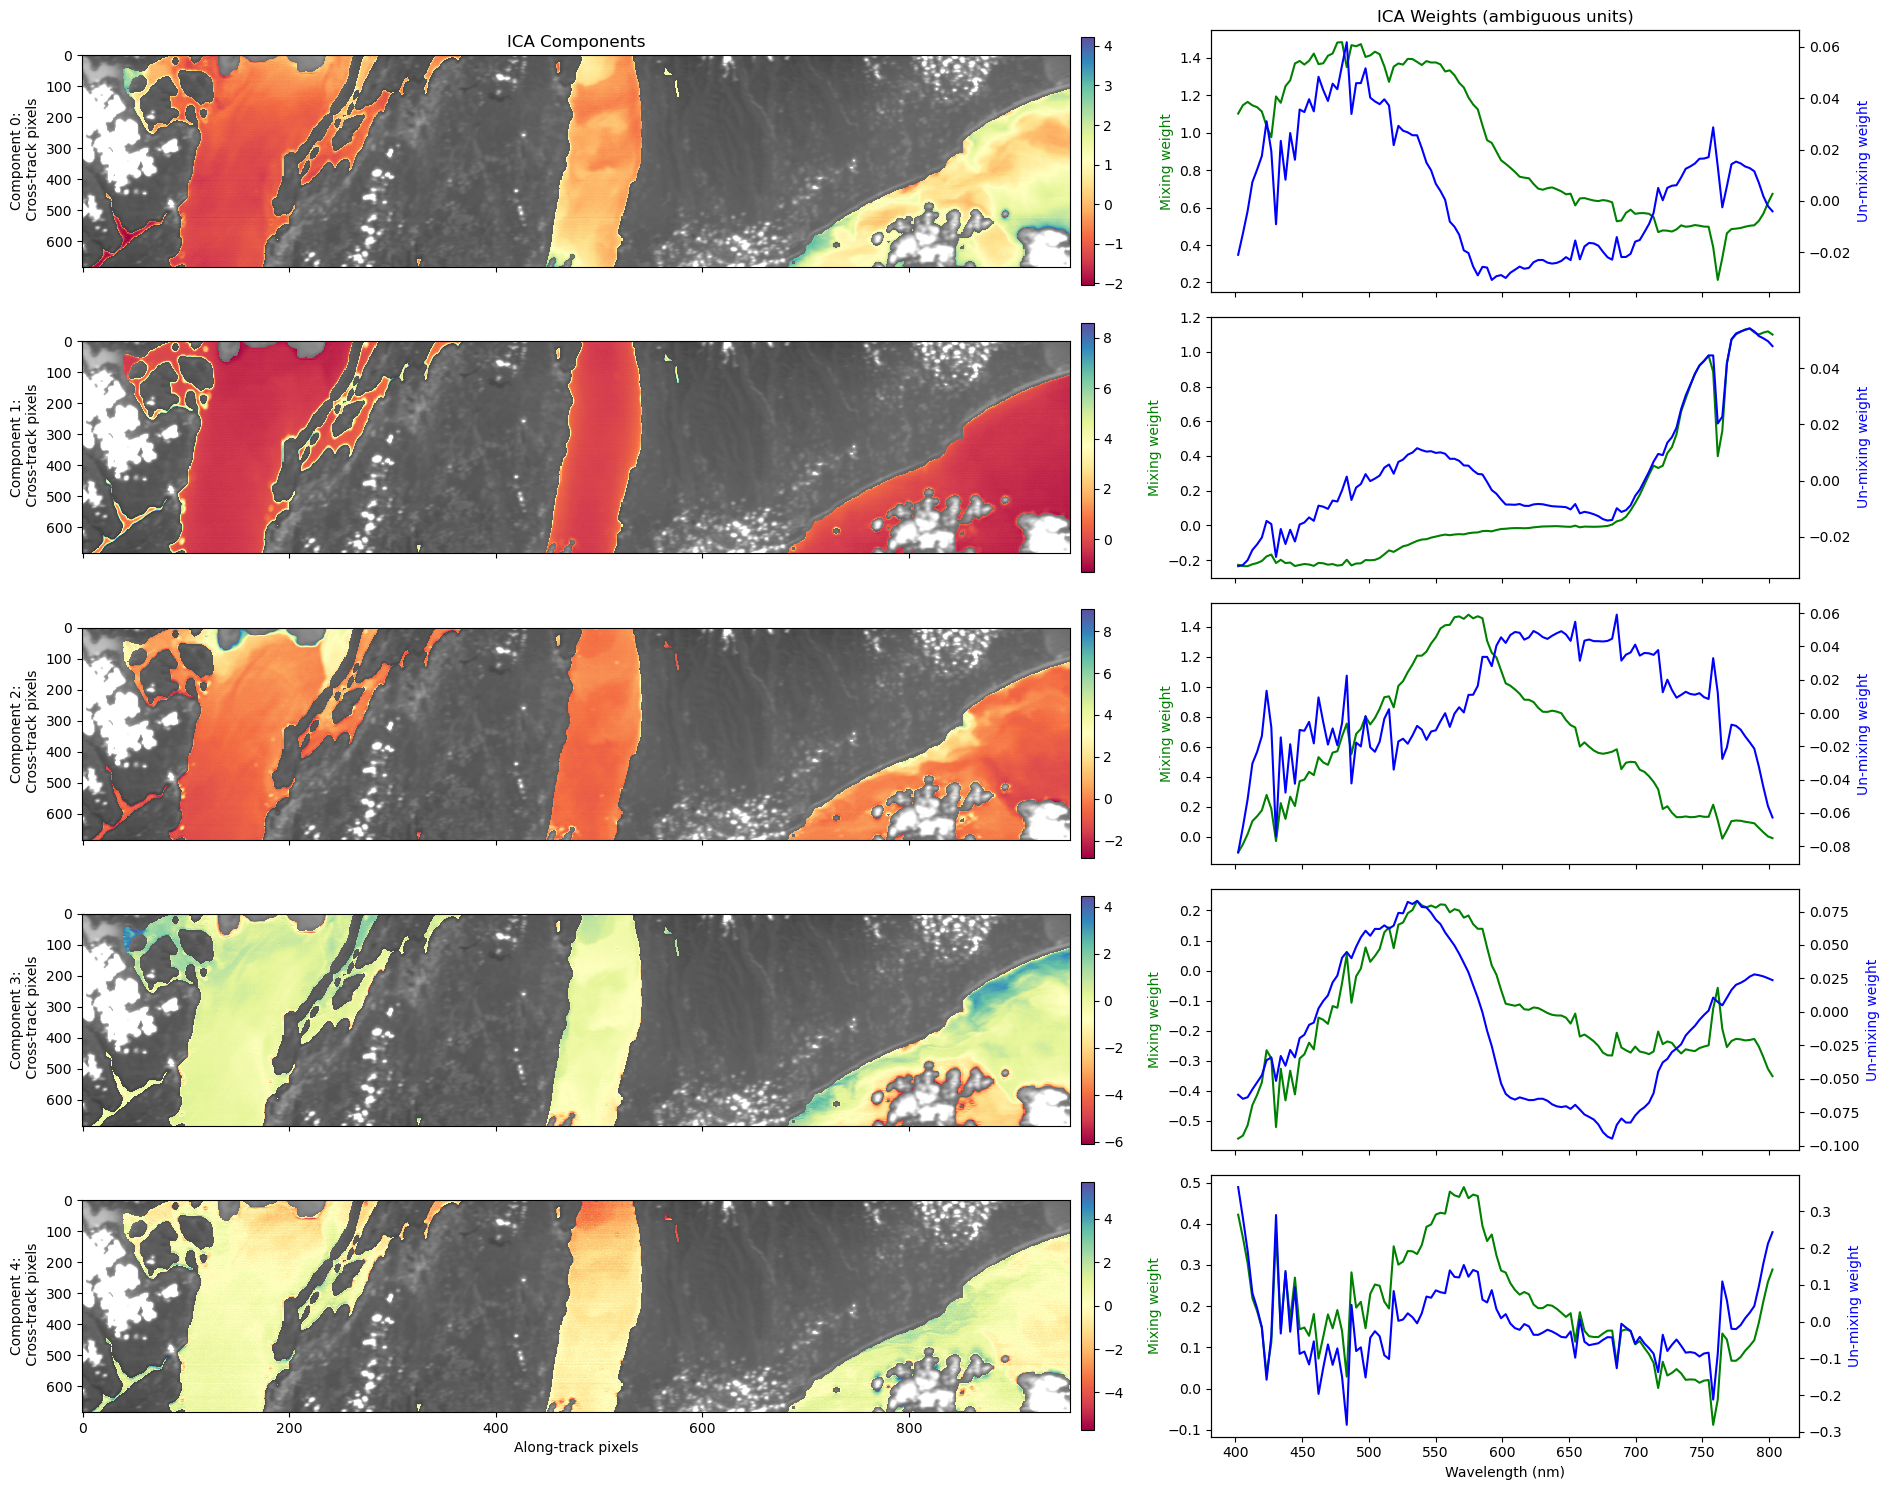

In [154]:
# Plot ICA results

fig, ax = plt.subplots(n_components,2,figsize=(19,15), gridspec_kw={'width_ratios': [2, 1]}, sharex='col')

# Plot data
for i in range(0,n_components):    

    # Plot ICA component
    mx = ma.masked_array(ica_components[:,:,i], mask=mask)
    ax[i,0].imshow(np.rot90(rgb_delined @ [0.299, 0.587, 0.114]),aspect=0.3, cmap='gray', vmin=0, vmax=1)
    im1 = ax[i,0].imshow(np.rot90(mx),aspect=0.3, cmap='Spectral', interpolation='nearest')
    
    if i == 0: 
        ax[i,0].set_title('ICA Components')

    ax[i,0].set_ylabel("Component " + str(i) + ":\n Cross-track pixels")
    plt.colorbar(im1, ax=ax[i,0], shrink=0.95, pad=0.01)

    if i == n_components-1:  
        ax[i,0].set_xlabel('Along-track pixels')
        
        
    # Plot spectrum
    if i == 0: 
        ax[i,1].set_title('ICA Weights (ambiguous units)')
        
    #fig, ax1 = plt.subplots()

    ax2 = ax[i,1].twinx()
    ax[i,1].plot(ica_wl, ica_mixing[:,i], label='ICA component ' + str(i), color='g')
    ax2.plot(ica_wl, ica_unmixing[:,i], label='ICA component ' + str(i), color='b')

    #ax1.set_xlabel('X data')
    ax[i,1].set_ylabel('Mixing weight', color='g')
    ax2.set_ylabel('Un-mixing weight', color='b')
                    
    if i == n_components-1:  
        ax[i,1].set_xlabel('Wavelength (nm)')
    
    fig.tight_layout() # Prevents label and title overlap
    
plt.savefig("./" + description + '_ica.png')

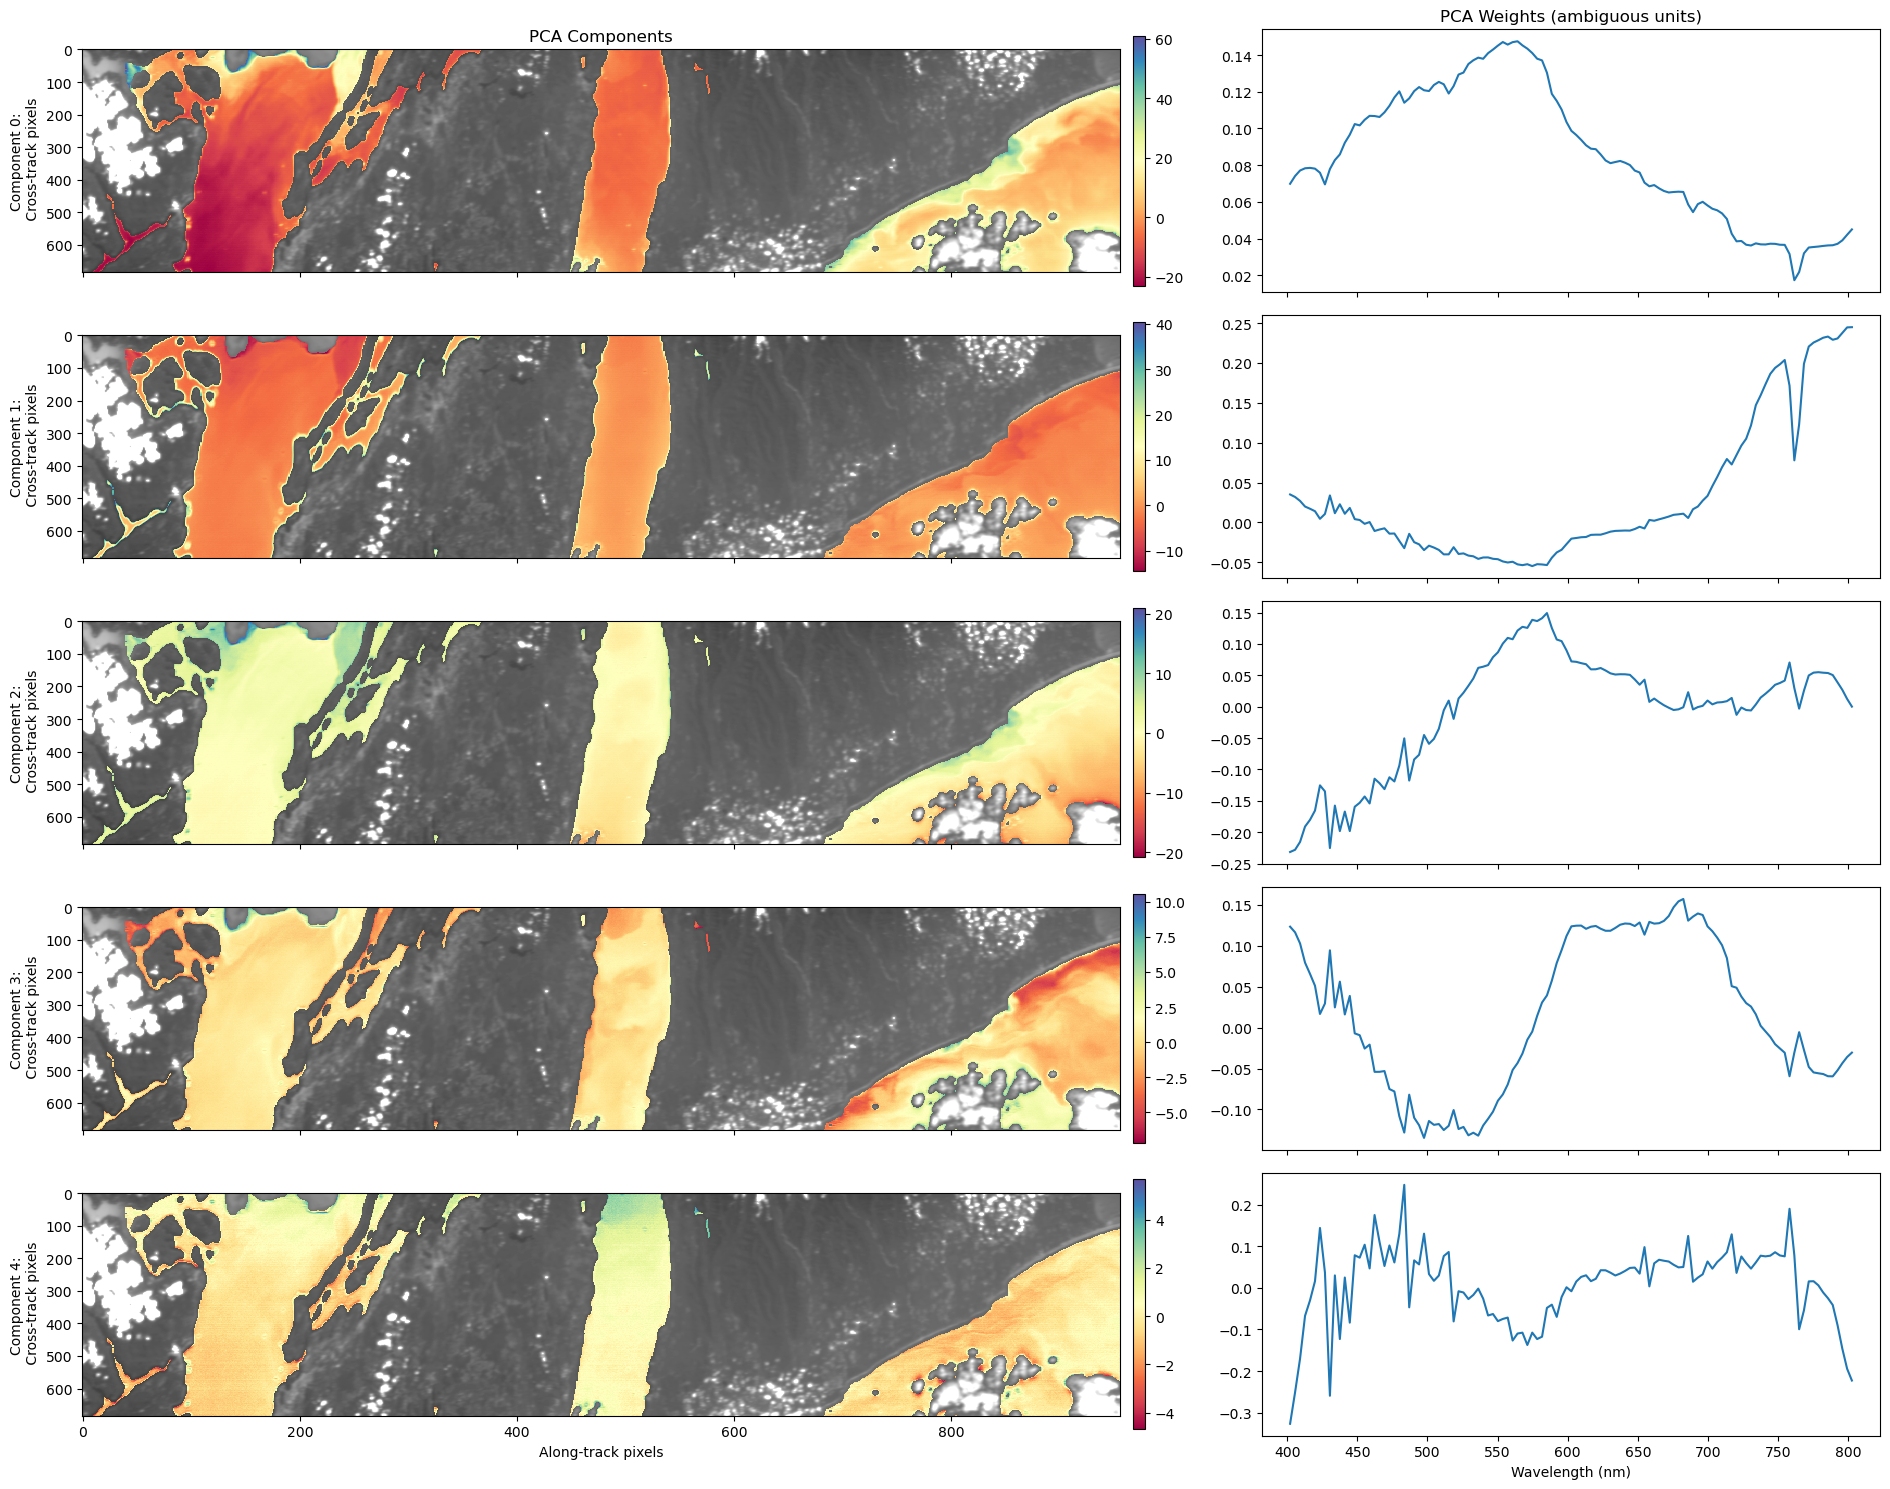

In [155]:
# Plot PCA results

fig, ax = plt.subplots(n_components,2,figsize=(19,15), gridspec_kw={'width_ratios': [2, 1]}, sharex='col')


# Plot data
for i in range(0,n_components):    

    # Plot PCA component
    mx = ma.masked_array(pca_components[:,:,i], mask=mask)
    ax[i,0].imshow(np.rot90(rgb_delined @ [0.299, 0.587, 0.114]),aspect=0.3, cmap='gray', vmin=0, vmax=1)
    im1 = ax[i,0].imshow(np.rot90(mx),aspect=0.3, cmap='Spectral', interpolation='nearest')
    
    if i == 0: 
        ax[i,0].set_title('PCA Components')

    ax[i,0].set_ylabel("Component " + str(i) + ":\n Cross-track pixels")
    plt.colorbar(im1, ax=ax[i,0], shrink=0.95, pad=0.01)

    if i == n_components-1:  
        ax[i,0].set_xlabel('Along-track pixels')

    # Plot spectrum
    if i == 0: 
        ax[i,1].set_title('PCA Weights (ambiguous units)')
        
    ax[i,1].plot(ica_wl, pca_unmixing[:,i], label='PCA component ' + str(i))
    #ax[i,1].set_title('ICA component ' + str(i) + ' spectrum')
    #ax[i,1].set_ylabel("ICA weight")
    #ax[i,1].legend(loc='upper left')
    
    if i == n_components-1:  
        ax[i,1].set_xlabel('Wavelength (nm)')
    
    fig.tight_layout() # Prevents label and title overlap
    
plt.savefig("./" + description + '_pca.png')